# IMDB Reviews Sentiment Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1 - Data Preprocessing

## 1.1. Download Dataset

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

import pandas as pd
df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist() 
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

Training set number: 25000
Testing set number: 25000


## 1.2. Preprocess data


Firstly, for the pre-processing method, it was found that some of the reviews contained html tags in the form of $<br />$. These were all replaced with empty strings as they serve no purpose to the sentiment classification problem. Secondly, all punctuation and anything that was not a word was filtered out from the dataset as I believe they will just add noise to the training process. While numbers might be useful in evaluating whether a review is positive or not (e.g. a person might say something along the lines of: 'I rate this film a 10 out of 10!'), it was found that at most times, the numbers were used to quote the length of the movie, a year, someone's age, part of the movie title or other aspects that are not useful for sentiment analysis (see output below). Although, there were still some cases where numbers were used to rate a film, I decided to only keep alpha characters (after converting all characters to lowercase) to simplify the vocabulary size and also to not risk adding noise to the dataset. Finally, it was decided to use a Porter stemmer over lemmatising. Although lemmatising has the ability to keep the resulting output as a word that can be found in a dictionary, I found that lemmatising will lemmatise both the words 'enjoy' and 'enjoyable' to themselves. However, stemming will stem both 'enjoy' and 'enjoyable' to 'enjoy', thus treating the 2 words as essentially the same (which is desirable, considering that both words have the same meaning but are just of different form). Finally, lemmatisation also cannot handle unknown words. In the case of this dataset, internet slang is used alot and it would be a good idea to keep them through stemming. Any contractions and english stop-words were also removed from the training and test set because these words won't help us to find the context of the review and also helps in reducing vocabulary size.

In [ ]:
### examine the use of numbers in the reviews 
reviews_with_nums = []
for review in reviews_train + reviews_test: 
    tokens = review.split(' ')
    for i in range(0, len(tokens)): 
        token = tokens[i]
        if token.isnumeric():
            #collect information on how the number is used. 
            reviews_with_nums.append(tokens[i-3:i+3])

In [ ]:
reviews_with_nums[:40]

[['sequel.', 'LITTLE', 'MERMAID', '2', 'gives', 'you'],
 ['away,', 'but', 'in', '75', 'minutes,', 'everything'],
 ['Disney,', 'LITTLE', 'MERMAID', '2', 'is', 'better'],
 ['/><br', '/>I', 'have', '3', 'more', 'of'],
 ['In', 'Don', "Siegel's", '1971', 'masterpiece', '"Dirty'],
 ["'Em", 'High"', 'in', '1986', 'plays', 'the'],
 ['after', 'the', 'brilliant', '1971', 'original.', 'An'],
 ['this', 'film', 'a', '7', 'out', 'of'],
 ['a', 'comedy.', 'Okay,', '106', 'minutes', "isn't"],
 ['minutes', 'let', 'alone', '106', 'minutes.', 'The'],
 ['a', 'show', 'after', '19', 'episodes', 'of'],
 ['in', 'the', 'first', '10', 'minutes', 'of'],
 ['in', 'the', 'first', '25', 'mins.', 'Each'],
 ['through', 'the', 'first', '25', 'mins', 'then'],
 ['as', 'the', 'original', '101', 'if', 'not'],
 ['a', 'group', 'of', '12', 'through', 'a'],
 ['was', 'an', 'Amelie', '2', '(per', 'the'],
 ['thrown', 'out', 'as', '4', 'young', 'guys'],
 ['woman', 'fleeing', 'from', '4', 'retarded', 'thugs,'],
 ['Amer', '-', 'about

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocess_data(reviews):
    """
    Performs preprocessing methods on all movie reviews including
    tokenization, lower case conversion, punctuation removal,
    stemming, stopword removal.
    """
    stop_words = set(stopwords.words('english')) 
    ps = PorterStemmer()

    cleaned_reviews = []

    for review in reviews: 

        cleaned_review = [] #stores cleaned sentences where each sentence is in a list

        sentences = sent_tokenize(review) #returns list of sentences 

        for sentence in sentences:

            #remove punctuation and convert to lower case 
            normalised_sentence = sentence.replace('<br />', '')
            normalised_sentence = re.sub(r"[^a-z]+", " ", normalised_sentence.lower())
            
            tokens = word_tokenize(normalised_sentence) #returns list of words

            #remove stopwords 
            tokens = [word for word in tokens if not word in stop_words]

            #stem each word in the review 
            tokens = [ps.stem(word) for word in tokens]  

            cleaned_review.append(tokens)
        
        cleaned_reviews.append(cleaned_review)

    return cleaned_reviews

In [ ]:
%%time 
### takes around 3 minutes 
train = preprocess_data(reviews_train)
test = preprocess_data(reviews_test)

CPU times: user 3min 53s, sys: 559 ms, total: 3min 53s
Wall time: 3min 53s


# 2 - Model Implementation

## 2.1. Word Embeddings

### 2.1.1. Data Preprocessing for Word Embeddings

For training the word embedding model, the same pre-processed reviews were used from the previous section i.e. html tags were removed, words were stemmed and only alpha-characters were kept. The reasons remain the same as stated above. Additionally, some extra pre-processing and filtering was done to create the vocabulary list. Firstly, rare words that occured less than 5 times in both the training and test set were removed. The reason for this was because I believe that words that rarely occur (such as movie titles, actor names, complex words that people often don't use, technical terms/jargon or perhaps even spelling errors) are most likely not useful for the sentiment classification process and would just create redundant noise in the model's learning process. Moreover, this also helps reduce the vocabulary size which makes training the word embedding model faster. Secondly, reviews were truncated to be at most 200 words long. This was done because it was found that approximately 87% of the reviews were less than 200 in length (see histogram below) and the maximum review length was over 1000 words long. Although cutting down reviews could result in information loss, if no truncation was done, then for the sequence model, I would have to pad all reviews to be approximately 1000 of length. However, too much padding is not ideal as this could lead to sparse sequences which may waste memory and also the longer sequences can cause slower training due to having to backpropagate over the entire sequence.  

Furthermore, a skipgram model was chosen for the word embedding model implementation. Although skip-gram models take longer to train than CBOW, they have been shown to work well when predicting rare words since it tries to predict the context word given the centre word. Given that there are a lot of words in the total reviews that are not used alot (e.g. there are a lot of words appearing 10 or 20 times out of the 50,000 reviews), I thought a skip-gram model would work better. Also, since the vocabulary size is not that big (approx. 25,000) after filtering,  training this type of model will not be that computationally inefficient. 

For the skipgram creations, a window size of 2 was used. I decided to use a small window size because as mentioned before, I did a lot of prior word filtering (especially since I filtered out 46,490 infrequently used words). Thus, even though the window size is 2, the range covered by this window size is actually alot larger because I may have taken out a lot of words from each sentence in each review. For that same reason, I avoided a larger window size of 3 or 4 as I believe that this will be too large, resulting in word-pairs where the centre word is not related to the specified context word. 


In [ ]:
from collections import Counter

def count_words(data, vocab_counter): 
    """
    Get the frequency (count) of each word.
    """
    for review in data:
        for sentence in review:
            for word in sentence: 
                vocab_counter[word] += 1
    return vocab_counter

In [ ]:
%%time 
vocab_counter = Counter()
vocab_counter = count_words(train, vocab_counter)
vocab_counter = count_words(test, vocab_counter)

CPU times: user 2.6 s, sys: 2 ms, total: 2.61 s
Wall time: 2.61 s


In [ ]:
### get rid of rare words according to some threshold  
min_threshold = 5
infrequent_words = {x : vocab_counter[x] for x in vocab_counter if vocab_counter[x] <= min_threshold}
len(infrequent_words)

46490

In [ ]:
def filter_infrequent_words(data): 
    """
    Filter out infrequent and weird words. 
    """
    new_data = []
    for review in data: #for each review 
        new_review = []
        for sentence in review: #for each sentence in the review 
            new_sentence = []
            for word in sentence: #for each word in the sentence 
                if word not in infrequent_words:
                   new_sentence.append(word)
            if new_sentence:
                new_review.append(new_sentence)
        if new_review:
            new_data.append(new_review)

    return new_data

In [ ]:
%%time 
cleaned_train = filter_infrequent_words(train)
cleaned_test = filter_infrequent_words(test)

CPU times: user 2.47 s, sys: 48 ms, total: 2.51 s
Wall time: 2.51 s


In [ ]:
def join_sentences(data):
    """
    Join the tokenized sentences in each review. 
    """
    reviews = []
    for review in data: 
        joined_review = sum(review, [])
        reviews.append(joined_review)
    return reviews

cleaned_train = join_sentences(cleaned_train)
cleaned_test = join_sentences(cleaned_test)

Proportion of reviews less than 100 in length: 0.86696


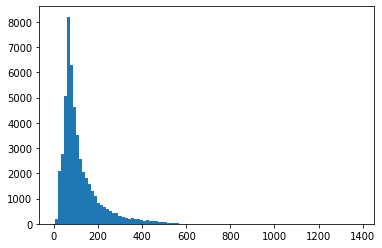

In [ ]:
### analyse the lengths of the reviews 
lengths = []
for review in cleaned_train + cleaned_test: 
    lengths.append(len(review))
short_reviews = [x for x in lengths if x <= 200]
print('Proportion of reviews less than 100 in length:', len(short_reviews)/len(lengths)) 

### create histogram of reviews 
plt.hist(lengths, bins=100)
plt.show()

In [ ]:
def truncate_reviews(data, max_review_len): 
    """
    Truncate reviews to the maximum review length.
    """
    new_data = []
    for review in data: 
        if len(review) > max_review_len:
            new_data.append(review[0:max_review_len])
        else:
            new_data.append(review)
    return new_data 

max_review_len = 200
cleaned_train = truncate_reviews(cleaned_train, max_review_len)
cleaned_test = truncate_reviews(cleaned_test, max_review_len)

In [ ]:
### create vocabulary list
def create_vocab_list(data, word_dict): 
    """
    Function to create the vocabulary list. 
    """
    for review in data:
        for word in review: 
            if word not in word_dict: 
                word_dict[word] = 0
    return word_dict

In [ ]:
%%time 
word_dict = {} #use dictionary for O(1) look ups 
word_dict = create_vocab_list(cleaned_train, word_dict)
word_dict = create_vocab_list(cleaned_test, word_dict)

CPU times: user 560 ms, sys: 2 ms, total: 562 ms
Wall time: 561 ms


In [ ]:
word_list = list(word_dict.keys())
len(word_list)

24463

In [ ]:
### create word mappings 
word_to_num = {w:num for (num, w) in enumerate(word_list)}
num_to_word = {num:w for (num, w) in enumerate(word_list)}

In [ ]:
skip_grams = []
window_size = 2

def create_skip_grams(data):
    """
    Function that takes in a list of reviews and creates 
    a list of skip-grams according to pre-defined window size. 
    """
    for review in data:
        #find matching number ids for each word in sentence 
        word_nums = [word_to_num[word] for word in review]

        for target_word_idx in range(0, len(word_nums)):
            #find matching number id for target (centre) word
            target_word_num = word_nums[target_word_idx]

            for w in range(-window_size, window_size+1): #search surroundings
                context_word_idx = target_word_idx + w

                #check for index out of bounds error or when context word == center word 
                if w == 0 or context_word_idx < 0 or context_word_idx >= len(word_nums):
                    continue 
                context_word_num = word_nums[context_word_idx] 
        
                skip_grams.append([target_word_num, context_word_num])

In [ ]:
%%time 
create_skip_grams(cleaned_train)
create_skip_grams(cleaned_test)
print(len(skip_grams))

20352980
CPU times: user 18 s, sys: 734 ms, total: 18.7 s
Wall time: 18.7 s


In [ ]:
### function for creating batches for the skipgram model
import numpy as np 
vocab_size = len(word_list)

def prepare_batch(skip_grams): 
    """
    Function to create inputs and labels for word embedding model. 
    Inputs are one-hot encoded centre words and labels are 
    simply the numerical representation of the context word. 
    
    """
    inputs, labels = [], []
    for sg in skip_grams:
        input_temp = [0] * vocab_size 
        input_temp[sg[0]] = 1 #centre word 
        inputs.append(input_temp)
        labels.append(sg[1]) #context word 

    return np.array(inputs), np.array(labels)

### 2.1.2. Build Word Embeddings Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
embedding_size = 100
learning_rate = 0.01
batch_size = 1000
total_epochs = 10000
vocab_size = len(word_list)

In [ ]:
class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        self.linear1 = nn.Linear(vocab_size, embedding_size, bias = False)
        self.linear2 = nn.Linear(embedding_size, vocab_size, bias = False)

    def forward(self, x):
        hidden = self.linear1(x)
        out = self.linear2(hidden) #no activation function because they're not neurons 
        #print(self.linear1.weight)
        return out

In [ ]:
net = SkipGram()
criterion = nn.CrossEntropyLoss() 
optimiser = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
net = torch.load('/content/drive/My Drive/COMP5046/Models/word_model_sg2_100.pt')

### 2.1.3. Train Word Embeddings Model

In [ ]:
### the training loss shown here are from the already pre-trained word embedding model 
import random 

losses = []

for epoch in range(total_epochs):

    random.shuffle(skip_grams)
    
    for i in range(0, len(skip_grams), batch_size): #for each batch 
        
        inputs, labels = prepare_batch(skip_grams[i:i+batch_size])
        inputs_torch = torch.from_numpy(inputs).float()
        labels_torch = torch.from_numpy(labels)

        net.train()
        optimiser.zero_grad() #zero out gradients after each batch

        outputs = net(inputs_torch) #forward propagate 
        loss = criterion(outputs, labels_torch) #calculate loss
        loss.backward() #backpropagate 
        optimiser.step()

        losses.append(loss.data)
        if i % 1000 == 0:
            print('Epoch: %d, batch loss (%d examples processed): %.4f' %(epoch + 1, i + 1000, losses[-1]))
 
        if i % 500000 == 0: 
            torch.save(net, '/content/drive/My Drive/COMP5046/word_model2_sg2_100.pt')
            np.save('/content/drive/My Drive/COMP5046/word_model2_sg2_100_loss.npy', losses) # save

Epoch: 1, batch loss (1000 examples processed): 7.5755


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SkipGram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, batch loss (2000 examples processed): 7.8823
Epoch: 1, batch loss (3000 examples processed): 7.7335
Epoch: 1, batch loss (4000 examples processed): 7.7127
Epoch: 1, batch loss (5000 examples processed): 7.7738
Epoch: 1, batch loss (6000 examples processed): 7.8015
Epoch: 1, batch loss (7000 examples processed): 7.6922
Epoch: 1, batch loss (8000 examples processed): 7.7578
Epoch: 1, batch loss (9000 examples processed): 7.6777
Epoch: 1, batch loss (10000 examples processed): 7.7706
Epoch: 1, batch loss (11000 examples processed): 7.6698
Epoch: 1, batch loss (12000 examples processed): 7.7973
Epoch: 1, batch loss (13000 examples processed): 7.8286
Epoch: 1, batch loss (14000 examples processed): 7.7796
Epoch: 1, batch loss (15000 examples processed): 7.7454
Epoch: 1, batch loss (16000 examples processed): 7.7376
Epoch: 1, batch loss (17000 examples processed): 7.8203
Epoch: 1, batch loss (18000 examples processed): 7.6932
Epoch: 1, batch loss (19000 examples processed): 7.8225


### 2.1.4. Save Word Embeddings Model

In [ ]:
torch.save(net, '/content/drive/My Drive/COMP5046/word_model_sg2_100.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SkipGram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.5. Load Word Embeddings Model

In [ ]:
word_emb_model = torch.load('/content/drive/My Drive/COMP5046/Models/word_model_sg2_100.pt')
word_emb_model.eval()

SkipGram(
  (linear1): Linear(in_features=24463, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=24463, bias=False)
)

In [ ]:
### extract weights from loaded model 
weight1 = word_emb_model.linear1.weight
word_embeddings = weight1.detach().T.numpy()
print(word_embeddings.shape) 

(24463, 100)


## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

For the pre-processing methods used in the character embedding model, I decided to keep the same pre-processed train and test reviews as used to train the word embedding model. The reason for this is that the vocabulary from the word embedding model should be the same vocabulary as the one used in the character embedding model as we are trying to find a character-based embedding for each word embedding that was pre-trained in section 2.1. Thus, if any different pre-processing technique was used (such as lemmatising instead of stemming), this might change the vocabulary.

However, additional pre-processing had to be performed before the character-embedding model could be implemented. Firstly, it was necessary to pad all the words in the vocabulary to be of the same size as all sequences fed into a neural sequence network must be of the same length. I found that the longest word in the vocabulary list was 72 characters long. However, the rest of the words were less than or equal to 16 characters. Thus, I decided to pad each word to 16 in length and truncate the word that was 72 characters long as padding all sequences to 72 in length would be a waste of memory, considering that we need to use one-hot encoding later. 

A look-up table was also created which was implemented as a python 'dictionary' where the key is the word and the value is the corresponding pre-trained word embedding obtained from section 2.1. This was done so that the word embedding for a word could be easily obtained during the training process of the character embedding model when we need to compare the loss between the character-based word embedding and the pre-trained word embedding vector. 

The longest word is:  blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah


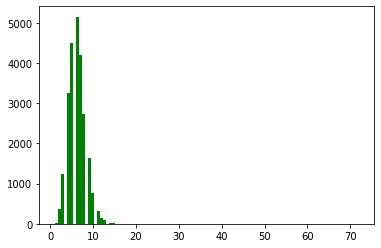

In [ ]:
### find really weird long words and plot word length distribution. 
word_lengths = []

for word in word_list:
    word_lengths.append(len(word))
    if len(word) > 16:
        print('The longest word is: ', word)

plt.hist(word_lengths, bins=100, color = 'green')
plt.show()

In [ ]:
char_arr = ['a', 'b', 'c', 'd', 'e', 'f', 'g',
            'h', 'i', 'j', 'k', 'l', 'm', 'n',
            'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']

char_arr.append('P') #let this be the padding character 

#{'a':0,....,'z:':25, 'P':26}
char_to_num = {n: i for i, n in enumerate(char_arr)}
dic_len = len(char_to_num)

max_word_len = 16
#print(max_word_len)

In [ ]:
def add_paddings(word, max_word_len):
    """
    Pad words that are shorter than max_word_len and
    truncate words that are longer than max_word_len.
    """
    diff = max_word_len - len(word)
    if len(word) > max_word_len:
        return word[0:max_word_len]
    for x in range(diff):
        word += "P"
    return word

In [ ]:
def create_lookup_table(word_list, word_embeddings): 
    """
    Create a dictionary where key is the word and value 
    is the associated word embedding obtained from the
    skipgram model.  
    """
    word_emb_map = {}
    for i in range(0, len(word_list)):
        word_emb_map[word_list[i]] = word_embeddings[i]

    return word_emb_map 

In [ ]:
%%time 
word_emb_map = create_lookup_table(word_list, word_embeddings)
print(len(word_emb_map))
print(len(word_emb_map['fun']))

24463
100
CPU times: user 11.1 ms, sys: 1 ms, total: 12.1 ms
Wall time: 11.9 ms


In [ ]:
def prepare_char_batch(data, word_emb_map): 
    """
    Function to create inputs and labels for character embedding model. 
    The inputs are one-hot encoded vectors of each character within the word.
    The labels are the pre-trained word embeddings. 
    """
    inputs, labels = [], []

    for word in data:
        #word = data[i]
        input_word = add_paddings(word, max_word_len)
        input_data = [char_to_num[char] for char in input_word] #returns a list 
        inputs.append(np.eye(dic_len)[input_data]) #convert char to one hot encoding 
        labels.append(word_emb_map[word])

    return np.array(inputs), np.array(labels)

In [ ]:
%%time 
inputs, labels = prepare_char_batch(word_list, word_emb_map)
print(inputs.shape)
print(labels.shape)

(24463, 16, 27)
(24463, 100)
CPU times: user 343 ms, sys: 85.1 ms, total: 429 ms
Wall time: 427 ms


### 2.2.2. Build Character Embeddings Model

To create the character embedding model, I decided to use a Cosine-Embedding loss function to compare the character-based word embedding with the pre-trained word embedding from the skipgram model. To do this, the output of the bi-LSTM has to be of the same size as the pre-trained word embeddings which were vectors of size 100. For this reason, the number of hidden units was decided to be 50. This is because after concatenating the last hidden states from the forward and backward pass in the bi-LSTM model, the resulting output would be a vector of size 100 which is the desired output size. It is noted that bi-LSTM was chosen as the model because such architectures have been shown to usually learn faster than the one-directional approach, especially for natural language processing tasks. Moreover, an RNN was avoided as they tend to not do well and experience vanishing gradients when dealing with long sequences.

### 2.1.4. Train Character Embeddings Model

In [ ]:
learning_rate = 0.01
total_epochs = 1000
batch_size = 128

n_hidden = 50
n_class = 100
n_input = dic_len #(of size 27)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [ ]:
class CharNet(nn.Module): 
    def __init__(self):
        super(CharNet, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first = True, bidirectional = True, dropout = 0.20)
        #multiply n_hidden by 2 since we concatenating hidden states 
        self.linear = nn.Linear(n_hidden * 2, n_class)

    def forward(self, x): 
        lstm_out, (h_n, c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[0,:,:], h_n[1,:,:]), 1)
        return hidden_out

In [ ]:
net = CharNet()
criterion = nn.CosineEmbeddingLoss()
optimiser = optim.Adam(net.parameters(), lr = learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
net = torch.load('/content/drive/My Drive/COMP5046/Models/char_model_sg2_100.pt')

In [ ]:
### the training loss shown here are from the already pre-trained character embedding model 

import random 

data = list(zip(inputs, labels))
losses = []
for epoch in range(total_epochs):

    random.shuffle(data)
    inputs, labels = zip(*data)
    inputs, labels = np.array(inputs), np.array(labels)

    for i in range(0, len(data), batch_size): #for each batch 
        inputs_batch = inputs[i:i+batch_size]
        labels_batch = labels[i:i+batch_size]
        inputs_batch_torch = torch.from_numpy(inputs_batch).float()
        labels_batch_torch = torch.from_numpy(labels_batch)

        net.train()
        optimiser.zero_grad() #zero out gradients after each batch

        outputs = net(inputs_batch_torch) #output is of size [batchsize, n_class] 
        y = torch.ones(len(outputs))
        loss = criterion(outputs, labels_batch_torch, y) #calculate loss
        loss.backward() #backpropagate 
        optimiser.step()

        losses.append(loss.data)
        if i % 100 == 0:
            print('Epoch: %d, batch loss (%d examples processed): %.4f' %(epoch + 1, i + 150, losses[-1]))

    if epoch % 100 == 0: 
        torch.save(net, '/content/drive/My Drive/COMP5046/char_model2_sg2_100.pt')
        np.save('/content/drive/My Drive/COMP5046/char_model2_sg2_100_loss.npy', losses) 

Epoch: 1, batch loss (150 examples processed): 0.5871
Epoch: 1, batch loss (3350 examples processed): 0.5809
Epoch: 1, batch loss (6550 examples processed): 0.5722
Epoch: 1, batch loss (9750 examples processed): 0.5790
Epoch: 1, batch loss (12950 examples processed): 0.5707
Epoch: 1, batch loss (16150 examples processed): 0.5905
Epoch: 1, batch loss (19350 examples processed): 0.5919
Epoch: 1, batch loss (22550 examples processed): 0.5832
Epoch: 2, batch loss (150 examples processed): 0.5697
Epoch: 2, batch loss (3350 examples processed): 0.5779
Epoch: 2, batch loss (6550 examples processed): 0.5836
Epoch: 2, batch loss (9750 examples processed): 0.5737
Epoch: 2, batch loss (12950 examples processed): 0.5725
Epoch: 2, batch loss (16150 examples processed): 0.5707
Epoch: 2, batch loss (19350 examples processed): 0.5719
Epoch: 2, batch loss (22550 examples processed): 0.5594
Epoch: 3, batch loss (150 examples processed): 0.5890
Epoch: 3, batch loss (3350 examples processed): 0.5718
Epoch

### 2.1.5. Save Character Embeddings Model

In [ ]:
torch.save(net, '/content/drive/My Drive/COMP5046/char_model_sg2_100.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.6. Load Character Embeddings Model

In [ ]:
char_emb_model = torch.load('/content/drive/My Drive/COMP5046/Models/char_model_sg2_100.pt')
char_emb_model.eval()

CharNet(
  (lstm): LSTM(27, 50, batch_first=True, dropout=0.2, bidirectional=True)
  (linear): Linear(in_features=100, out_features=100, bias=True)
)

In [ ]:
%%time 
inputs, labels = prepare_char_batch(word_list, word_emb_map)
inputs_torch = torch.from_numpy(inputs).float() #make sure the order of the words are kept 
hidden_state = char_emb_model(inputs_torch) #hidden state should be of size (vocab_size, 100)

CPU times: user 2.19 s, sys: 789 ms, total: 2.98 s
Wall time: 2.07 s


In [ ]:
print('Char embeddings shape:', hidden_state.shape)
#convert to torch object for concatenation 
word_embeddings_torch = torch.from_numpy(word_embeddings).float()
print('Word embeddings shape:', word_embeddings_torch.shape)

Char embeddings shape: torch.Size([24463, 100])
Word embeddings shape: torch.Size([24463, 100])


## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

Not much pre-processing is done in this section. The same cleaned train and test reviews as defined above were used for this section. The only additional pre-processing was to add padding to the reviews that were shorter than 200 words to ensure that all sequences were of equal length.

In [ ]:
# concatenate character-based embeddings and word embeddings 
final_embeddings = torch.cat((word_embeddings_torch, hidden_state), 1)
print('Shape of the final embeddings:',  final_embeddings.shape)

Shape of the final embeddings: torch.Size([24463, 200])


In [ ]:
def create_final_embedding_lookup(word_list, final_embeddings):
    """
    Create lookup table for the final word embeddings. The 
    key is the word and the value is the final word embedding.
    """
    final_emb_map = {}
    for i in range(0, len(word_list)):
        word = word_list[i]
        final_emb_map[word] = final_embeddings[i]

    ### add padding embedding
    final_emb_map['P'] = torch.zeros(final_embeddings.shape[1]).float()

    return final_emb_map

In [ ]:
%%time 
final_emb_map = create_final_embedding_lookup(word_list, final_embeddings)
len(final_emb_map)

CPU times: user 64.9 ms, sys: 0 ns, total: 64.9 ms
Wall time: 64.5 ms


In [ ]:
def find_most_similar(word, word_emb_map, top_n):
    """
    Given a word, finds the top n most similar word based on cosine similarity.
    """
    cos = nn.CosineSimilarity(dim=0)

    input1 = word_emb_map[word]
    similarities = {}

    for key in word_emb_map.keys():

        if word == key or key == 'P': #ignore padding 
            continue 

        input2 = word_emb_map[key]
        similarity = cos(input1, input2).data
        similarities[key] = similarity

    similarities = {k: v for k, v in sorted(similarities.items(), key=lambda item: item[1],
                                            reverse = True)}
    result = {k: similarities[k] for k in list(similarities)[:top_n]}
    return result

In [ ]:
print(find_most_similar('great', final_emb_map, 5))
print(find_most_similar('think', final_emb_map, 5))

{'good': tensor(0.7654), 'wonder': tensor(0.7639), 'fine': tensor(0.7373), 'well': tensor(0.7343), 'fantast': tensor(0.7182)}
{'could': tensor(0.7888), 'say': tensor(0.7627), 'believ': tensor(0.7462), 'like': tensor(0.7455), 'know': tensor(0.7407)}


In [ ]:
def pad_reviews(data, max_review_len): 
    """
    Pad review sequences to the same length. 
    """
    new_data = []
    for review in data: 
        diff = max_review_len - len(review)
        if diff > 0: 
            padding = ["P"]*diff #use pre-padding 
            new_data.append(padding + review)
        else:
            new_data.append(review[0:max_review_len])

    return new_data 

In [ ]:
%%time 
#1000 is too long, cap it at 200
max_review_len = 200

train_reviews = pad_reviews(cleaned_train, max_review_len)
test_reviews = pad_reviews(cleaned_test, max_review_len)

CPU times: user 909 ms, sys: 2.98 ms, total: 912 ms
Wall time: 910 ms


In [ ]:
def prepare_batch_reviews(data, labels, final_emb_map): 
    """
    Function to prepare batch for sentiment classifier. The 
    inputs are the words from the reviews represented by their 
    final word embeddings. The labels are the sentiment (pos or neg). 
    """
    input_sequences, targets = [], []

    for review in data:
        sequence = []
        for word in review:
            sequence.append(final_emb_map[word].detach().numpy())
        input_sequences.append(np.array(sequence))

    for label in labels: 
        if label == 'pos':
            targets.append(1)
        else: 
            targets.append(0)

    return np.array(input_sequences), np.array(targets)


In [ ]:
### testing prepare_batch_reviews function
x, y = prepare_batch_reviews(train_reviews[20:30], sentiments_train[20:30], final_emb_map)

### 2.3.2. Build Sequence Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from sklearn.metrics import accuracy_score

In [ ]:
total_epochs = 2
batch_size = 256
seq_length = 200

n_input = 200 #word embedding size 
n_class = 2
n_hidden = 100
n_layers = 1
dropout = 0.20
learning_rate = 0.01

In [ ]:
class SentimentClassifier(nn.Module): 
    def __init__(self): 
        super(SentimentClassifier, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers = n_layers, 
                            batch_first = True, bidirectional = True, dropout = dropout)
        self.linear = nn.Linear(n_hidden*2, n_class, bias = True)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        #concatenate the final forward and final backward hidden state 
        hidden_out = torch.cat((hidden[0,:,:], hidden[1,:,:]), dim = 1)
        z = self.linear(hidden_out)
        log_output = F.log_softmax(z, dim = 1) #take log of softmax 
        return log_output


In [ ]:
sent_net = SentimentClassifier()
criterion = nn.NLLLoss()
optimiser = optim.Adam(sent_net.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
sent_net = torch.load('/content/drive/My Drive/COMP5046/Models/sentiment_model.pt')

### 2.3.3. Train Sequence Model

In [ ]:
### Note that the training loss shown here is obtained from only 2 epochs. 

import random 

losses = []
accuracies = []
data = list(zip(train_reviews, sentiments_train))

for epoch in range(total_epochs): 

    random.shuffle(data) #shuffle data 
    inputs, labels = zip(*data)
    inputs, labels = np.array(inputs), np.array(labels)

    for i in range(0, len(data), batch_size): 
        inputs_batch = inputs[i:i+batch_size]
        labels_batch = labels[i:i+batch_size]

        inputs_batch, labels_batch = prepare_batch_reviews(inputs_batch, labels_batch, final_emb_map)
        inputs_batch_torch = torch.from_numpy(inputs_batch).float()
        labels_batch_torch = torch.from_numpy(labels_batch)
        
        sent_net.train()
        outputs = sent_net(inputs_batch_torch)
        loss = criterion(outputs, labels_batch_torch) 
        loss.backward() 
        optimiser.step()
        optimiser.zero_grad()

        losses.append(loss.data)

        if i % 1 == 0:
            sent_net.eval()
            outputs = sent_net(inputs_batch_torch)
            # Evaluation loss and accuracy calculation
            loss = criterion(outputs, labels_batch_torch)
            _, predicted = torch.max(outputs, 1)
            acc = accuracy_score(predicted.numpy(),labels_batch_torch.numpy())
            accuracies.append(acc)
            print('Epoch: %d, Batch: %d, loss: %.5f, train_acc: %.2f' %(epoch + 1, i + batch_size, loss.item(), acc))
        
        if i % 5 == 0: #save loss and final model every 5 iterations 
            torch.save(sent_net, '/content/drive/My Drive/COMP5046/sentiment_model.pt')
            np.save('/content/drive/My Drive/COMP5046/sentiment_model_loss.npy', losses) # save
        
        if i % batch_size * 10 == 0: #save every 10 iterations 
            torch.save(sent_net, '/content/drive/My Drive/COMP5046/sentiment_model_{}_{}.pt'.format(epoch,i))
            

Epoch: 1, Batch: 256, loss: 0.75811, train_acc: 0.54
Epoch: 1, Batch: 512, loss: 0.69840, train_acc: 0.58
Epoch: 1, Batch: 768, loss: 0.69578, train_acc: 0.49
Epoch: 1, Batch: 1024, loss: 0.69451, train_acc: 0.45
Epoch: 1, Batch: 1280, loss: 0.68688, train_acc: 0.54
Epoch: 1, Batch: 1536, loss: 0.68813, train_acc: 0.65
Epoch: 1, Batch: 1792, loss: 0.68766, train_acc: 0.58
Epoch: 1, Batch: 2048, loss: 0.68584, train_acc: 0.62
Epoch: 1, Batch: 2304, loss: 0.68527, train_acc: 0.64
Epoch: 1, Batch: 2560, loss: 0.68376, train_acc: 0.62
Epoch: 1, Batch: 2816, loss: 0.67825, train_acc: 0.61
Epoch: 1, Batch: 3072, loss: 0.67942, train_acc: 0.60
Epoch: 1, Batch: 3328, loss: 0.66190, train_acc: 0.70
Epoch: 1, Batch: 3584, loss: 0.65830, train_acc: 0.64
Epoch: 1, Batch: 3840, loss: 0.63148, train_acc: 0.69
Epoch: 1, Batch: 4096, loss: 0.58716, train_acc: 0.75
Epoch: 1, Batch: 4352, loss: 0.57979, train_acc: 0.69
Epoch: 1, Batch: 4608, loss: 0.87048, train_acc: 0.55
Epoch: 1, Batch: 4864, loss: 0.

### 2.3.4. Save Sequence Model

In [ ]:
torch.save(sent_net, '/content/drive/My Drive/COMP5046/sentiment_model.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SentimentClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.3.5. Load Sequence Model

In [ ]:
sentiment_model = torch.load('/content/drive/My Drive/COMP5046/Models/sentiment_model.pt')
sentiment_model.eval()
sentiment_model.parameters

<bound method Module.parameters of SentimentClassifier(
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.2, bidirectional=True)
  (linear): Linear(in_features=200, out_features=2, bias=True)
)>

# 3 - Evaluation


## 3.1. Performance Evaluation



In [ ]:
def evaluate_test(test_reviews, sentiments_test, sentiment_model): 
    """
    Function that evaluates that returns the predictions from 
    the test set given the sentiment model.
    """
    
    test_predictions = [] #stores model predictions
    true = [] #stores ground truth values 

    batch_size = 256 
    data_test = list(zip(test_reviews, sentiments_test))
    inputs, labels = zip(*data_test)
    inputs, labels = np.array(inputs), np.array(labels)

    for i in range(0, len(data_test), batch_size): 
        inputs_batch = inputs[i:i+batch_size]
        labels_batch = labels[i:i+batch_size]
        inputs_batch, labels_batch = prepare_batch_reviews(inputs_batch, labels_batch, final_emb_map)
        true += list(labels_batch)
        inputs_batch_torch = torch.from_numpy(inputs_batch).float()
        
        print('Number of reviews evaluated: ', i + batch_size)

        sentiment_model.eval()

        outputs = sentiment_model(inputs_batch_torch)
        _, predicted = torch.max(outputs, 1)
        test_predictions += list(predicted.numpy())
    
    return true, test_predictions

In [ ]:
%%time 
true, test_predictions = evaluate_test(test_reviews, sentiments_test, sent_net)

Number of reviews evaluated:  256
Number of reviews evaluated:  512
Number of reviews evaluated:  768
Number of reviews evaluated:  1024
Number of reviews evaluated:  1280
Number of reviews evaluated:  1536
Number of reviews evaluated:  1792
Number of reviews evaluated:  2048
Number of reviews evaluated:  2304
Number of reviews evaluated:  2560
Number of reviews evaluated:  2816
Number of reviews evaluated:  3072
Number of reviews evaluated:  3328
Number of reviews evaluated:  3584
Number of reviews evaluated:  3840
Number of reviews evaluated:  4096
Number of reviews evaluated:  4352
Number of reviews evaluated:  4608
Number of reviews evaluated:  4864
Number of reviews evaluated:  5120
Number of reviews evaluated:  5376
Number of reviews evaluated:  5632
Number of reviews evaluated:  5888
Number of reviews evaluated:  6144
Number of reviews evaluated:  6400
Number of reviews evaluated:  6656
Number of reviews evaluated:  6912
Number of reviews evaluated:  7168
Number of reviews evalu

In [ ]:
### checking lengths of list match 
print('Number of examples:', len(true))
print('Number of predicted examples:', len(test_predictions))

Number of examples: 25000
Number of predicted examples: 25000


In [ ]:
def calculate_metrics(true, predicted, class1, class2): 
    """
    Function to calculate precision, recall and F1 score given predictions
    and the ground truth. 
    """
    true_positives = 0 
    false_positives = 0
    false_negatives = 0

    for i in range(0, len(true)): 
        if true[i] == class1 and predicted[i] == class1: 
            true_positives += 1
        elif true[i] == class2 and predicted[i] == class1: 
            false_positives += 1
        elif true[i] == class1 and predicted[i] == class2:
            false_negatives += 1
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = (2 * precision * recall)/(precision + recall)

    return precision, recall, f1 

In [ ]:
%%time 
precision_pos, recall_pos, f1_pos = calculate_metrics(true, test_predictions, 1, 0)
precision_neg, recall_neg, f1_neg = calculate_metrics(true, test_predictions, 0, 1)

CPU times: user 31.8 ms, sys: 0 ns, total: 31.8 ms
Wall time: 31.5 ms


In [ ]:
### check how many of each class
print(Counter(true).keys())
print(Counter(true).values())

dict_keys([1, 0])
dict_values([12500, 12500])


In [ ]:
### compile the results in a table and print. 
import pandas as pd

results_dict = {'precision': [precision_neg, precision_pos, 0.5*(precision_neg + precision_pos)], 
                'recall': [recall_neg, recall_pos, 0.5 * (recall_neg + recall_pos)],
                'f1-score': [f1_neg, f1_pos, 0.5*(f1_neg + f1_pos)], 
                'support': [12500, 12500, 25000],
                'class' : ['neg', 'pos', 'weighted']}

results = pd.DataFrame.from_dict(results_dict)
results.set_index('class', inplace = True)

print('Confusion matrix for the test set')
print('-----------------------------------------------')
print(results)
print('-----------------------------------------------')

### calculate the test accuracy 
correct = 0
for i in range(len(test_predictions)): 
    if test_predictions[i] == true[i]:
        correct += 1
print('The test accuracy is: %.2f percent' %(correct*100/len(test_predictions)))

Confusion matrix for the test set
-----------------------------------------------
          precision   recall  f1-score  support
class                                          
neg        0.912092  0.79352  0.848684    12500
pos        0.817274  0.92352  0.867155    12500
weighted   0.864683  0.85852  0.857920    25000
-----------------------------------------------
The test accuracy is: 85.85 percent


Looking at the confusion matrix, we can see that precision and recall for both classes are ranging from approximately 80-90%. The high precision and recall indicates that the model has high true positives and negatives and low false positives and false negatives. Given that precision is over 90% while recall is 79.35% for the negative class, we can also infer that false negatives for this class tend to be higher while false positives are lower. The reverse is true for the positive class. As recall is above 90% and precision is lower at 81.72%, the model seems to have more trouble in minimising false positives compared to false negatives. Nevertheless, the weighted F1-scores and accuracy are high (over 85%) which indicates that the model performs quite well on the test set in addition to the training set.





## 3.2. Hyperparameter Testing


In [ ]:
%%time 
import os 

### Load the trained models from different epochs and evaluate on the test set and 
### store the f1 scores for positive and negative sentiment in lists. 
### The model is evaluated every 10 iterations. 
### Note that you don't need to run this cell. 

path = '/content/drive/My Drive/COMP5046/sg2_emb100_nhidden100_nlayer1/' 
f1_scores_pos = []
f1_scores_neg = []

count = 0
for model_name in os.listdir(path): 
    if count % 10 == 0: #evaluate results for every 10 iterations. 
        print(model_name)
        model = torch.load(path + model_name)
        true, test_predictions = evaluate_test(test_reviews, sentiments_test, model)
        _, _, f1_pos = calculate_metrics(true, test_predictions, 1, 0)
        _, _, f1_neg = calculate_metrics(true, test_predictions, 0, 1)
        print(f1_pos, f1_neg)
        f1_scores_pos.append(f1_pos)
        f1_scores_neg.append(f1_neg)
    count += 1

## save f1 scores 
np.save('/content/drive/My Drive/COMP5046/test_f1_score_pos.npy', f1_scores_pos)
np.save('/content/drive/My Drive/COMP5046/test_f1_score_neg.npy', f1_scores_neg)

sentiment_model_0_0.pt
Number of reviews evaluated:  256
Number of reviews evaluated:  512
Number of reviews evaluated:  768
Number of reviews evaluated:  1024
Number of reviews evaluated:  1280
Number of reviews evaluated:  1536
Number of reviews evaluated:  1792
Number of reviews evaluated:  2048
Number of reviews evaluated:  2304
Number of reviews evaluated:  2560
Number of reviews evaluated:  2816
Number of reviews evaluated:  3072
Number of reviews evaluated:  3328
Number of reviews evaluated:  3584
Number of reviews evaluated:  3840
Number of reviews evaluated:  4096
Number of reviews evaluated:  4352
Number of reviews evaluated:  4608
Number of reviews evaluated:  4864
Number of reviews evaluated:  5120
Number of reviews evaluated:  5376
Number of reviews evaluated:  5632
Number of reviews evaluated:  5888
Number of reviews evaluated:  6144
Number of reviews evaluated:  6400
Number of reviews evaluated:  6656
Number of reviews evaluated:  6912
Number of reviews evaluated:  7168


Text(0, 0.5, 'f1-score')

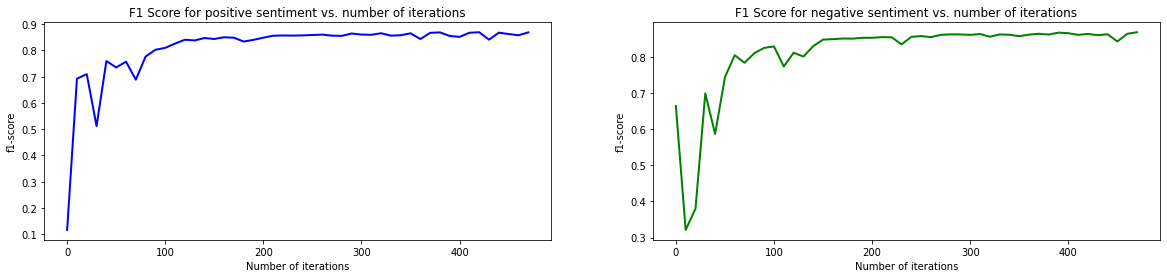

In [ ]:
### plot graph of f1-scores versus number of iterations. 
f1_scores_pos = np.load('/content/drive/My Drive/COMP5046/test_f1_score_pos.npy')
f1_scores_neg = np.load('/content/drive/My Drive/COMP5046/test_f1_score_neg.npy')

x = np.arange(0, 480, 10)

fig, ax = plt.subplots(1,2, figsize = (20,4))
ax[0].plot(x, f1_scores_pos, color = 'blue', linewidth = 2)
ax[0].set_title('F1 Score for positive sentiment vs. number of iterations')
ax[0].set_xlabel('Number of iterations')
ax[0].set_ylabel('f1-score')

ax[1].plot(x, f1_scores_neg, color = 'green', linewidth = 2)
ax[1].set_title('F1 Score for negative sentiment vs. number of iterations')
ax[1].set_xlabel('Number of iterations')
ax[1].set_ylabel('f1-score')

Text(0.5, 1.0, 'Weighted F1-score for test vs. number of iterations')

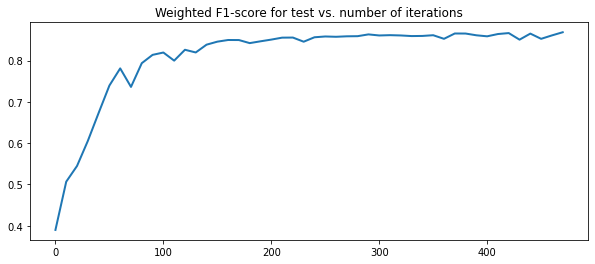

In [ ]:
### Results are obtained with bi-LSTM model with 1 layer, 100 hidden units, Adam optimiser and 0.01 learning rate.
### compute weighted f1-scores and plot. 
f1_weighted = []
for i in range(0, len(f1_scores_pos)): 
    f1_weighted.append(0.5*(f1_scores_pos[i] + f1_scores_neg[i]))

fig, ax = plt.subplots(figsize = (10,4))
ax.plot(x, f1_weighted, linewidth = 2)
ax.set_title('Weighted F1-score for test vs. number of iterations')

The weighted F1-score seems to converge to approximately 85% on the test set after 300 iterations. Thus, the optimal number of iterations is around 300. 